In [13]:
# defining root location of the project on local system (change this to your own path after pulling)
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# set up plotting config
mpl.rcParams['mathtext.fontset'] = 'stix'  # or 'dejavusans', 'cm', 'custom'
mpl.rcParams['font.family'] = 'STIXGeneral'  # Matches STIX math font
# set tick font size
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
# set default fontsize
mpl.rcParams['font.size'] = 16


# function to convert hex color to rgb tuple
def hex2rgb(hex: str) -> tuple[float, float, float]:
    rbg = tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))
    return tuple([c/255 for c in rbg])


colorI, colorII, colorIII = hex2rgb('71A8C4'), hex2rgb('EACEBD'), hex2rgb('F8A17B')

# define root
ROOT = "/home/andreasstillits/coding/Leaves1D/"
%cd $ROOT

/home/andreasstillits/coding/Leaves1D


### Helper functions

In [14]:
def map_data_values(df: pd.DataFrame, map: np.ndarray, vmin: float = 0.01, vmax: float = 100) -> np.ndarray:
    taus_data = df['tau'].to_numpy()
    gammas_data = df['gamma'].to_numpy()
    N_gamma, N_tau = map.shape 
    taus = np.exp(np.linspace(np.log(vmin), np.log(vmax), N_tau))
    gammas = np.exp(np.linspace(np.log(vmin), np.log(vmax), N_gamma))
    log_taus = np.log(taus)
    log_gammas = np.log(gammas)
    
    values = []
    for tau_data, gamma_data in zip(taus_data, gammas_data):
        # Handle out-of-bounds values by clipping to grid range via nearest neighbour
        if (tau_data <= taus[0]) or (tau_data >= taus[-1]) or (gamma_data <= gammas[0]) or (gamma_data >= gammas[-1]):
            idx_tau = int(np.argmin(np.abs(taus - tau_data)))
            idx_gamma = int(np.argmin(np.abs(gammas - gamma_data)))
            values.append(map[idx_gamma, idx_tau])
            continue

        # Work in log-space for interpolation weights
        log_tau_data = np.log(tau_data)
        log_gamma_data = np.log(gamma_data)

        # Find indices of the two neighbouring grid points in each direction (in log-space)
        idx_tau_upper = int(np.searchsorted(log_taus, log_tau_data, side="right"))
        idx_tau_lower = idx_tau_upper - 1
        idx_gamma_upper = int(np.searchsorted(log_gammas, log_gamma_data, side="right"))
        idx_gamma_lower = idx_gamma_upper - 1

        x0, x1 = log_taus[idx_tau_lower], log_taus[idx_tau_upper]
        y0, y1 = log_gammas[idx_gamma_lower], log_gammas[idx_gamma_upper]

        f00 = map[idx_gamma_lower, idx_tau_lower]
        f10 = map[idx_gamma_lower, idx_tau_upper]
        f01 = map[idx_gamma_upper, idx_tau_lower]
        f11 = map[idx_gamma_upper, idx_tau_upper]

        tx = (log_tau_data - x0) / (x1 - x0)
        ty = (log_gamma_data - y0) / (y1 - y0)

        value = (
            (1 - tx) * (1 - ty) * f00 +
            tx * (1 - ty) * f10 +
            (1 - tx) * ty * f01 +
            tx * ty * f11
)
        values.append(value)

    return np.array(values)
    
def std_layout(ax: plt.Axes, dataframes: list[pd.DataFrame], labels=list[str], colors: list[str] = ["darkblue", "darkred", "darkgreen"], alphas: list[float] = [1.0, 1.0, 1.0], vmin: float = 0.01, vmax: float = 100, inset: bool = False) -> None:
    """Helper function to set standard plot settings for (tau,gamma) figures."""
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(vmin, vmax)
    ax.set_ylim(vmin, vmax)
    ax.plot([1, 1], [vmin, vmax], color="grey", linestyle="-.", zorder=2)
    ax.plot([vmin, vmax], [1, 1], color="grey", linestyle="-.", zorder=2)

    markersize = 25 if not inset else 10

    for df, color, label, alpha in zip(dataframes, colors, labels, alphas):
        ax.scatter(df['tau'], df['gamma'], color=color, marker="o", zorder=3, label=label, s=markersize, alpha=alpha)

    if not inset:
        ax.set_xlabel(r"Absorption balance $\tau$ []")
        ax.set_ylabel(r"Transport balance $\gamma$ []")
        ax.legend(loc="upper left", fontsize=10)            

def std_histogram(ax: plt.Axes, xlabel: str = "tau") -> None:
    ax.set_ylabel('Count')
    if xlabel == "tau":
        ax.set_xlabel(r"Absorption balance $\tau$ []")
    elif xlabel == "gamma":
        ax.set_xlabel(r"Transport balance $\gamma$ []")
    else:
        ax.set_xlabel(xlabel)
    ax.set_xscale('log')
    ax.legend(loc="upper right", fontsize=10)
    return

### Figure SX - underestimates of stomatal conductance $g_s$

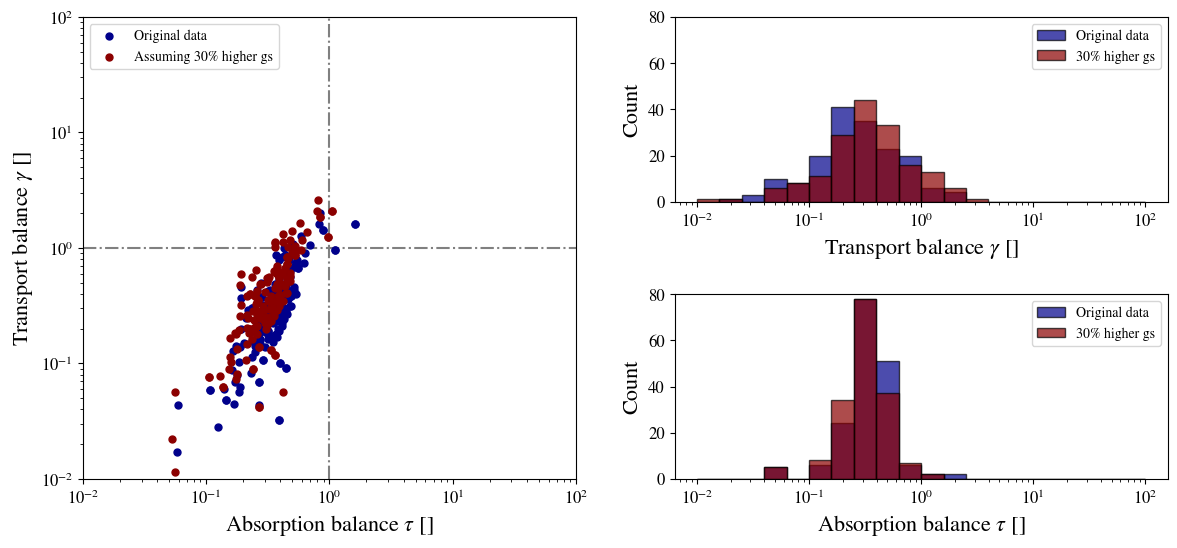

In [29]:
from python_module.interface import numpy_estimate_parameters
np.random.seed(142)  # for reproducibility

# load data
df = pd.read_csv(ROOT + "supplementary/files/data/Knauer2022_pre_tau_gamma.csv", decimal=',', sep=';')
gs = df["stomatal_conductance"].to_numpy()
gias = df["ias_conductance"].to_numpy()
gm = df["mesophyll_conductance*"].to_numpy()
An = df["An"].to_numpy() 
Ci = df["substomatal_conc"].to_numpy()
C_ = df["compensation_point"].to_numpy() 
Ca = df["Ca_gas_exchange"].to_numpy()


# original values
taus, gammas = numpy_estimate_parameters(gm, gs, gias)
df = pd.DataFrame({"tau": taus, "gamma": gammas})

# now assume gs to be 30% higher than it is, then probagate to Ci and gm
factor = 0.30
gs_new = (1 + factor) * gs 
Ci_new = Ca - An / gs_new
gm_new = An / (Ci_new - C_)

taus_new, gammas_new = numpy_estimate_parameters(gm_new, gs_new, gias)
df_new = pd.DataFrame({"tau": taus_new, "gamma": gammas_new})

fig = plt.figure(figsize=(14, 6))
spec = fig.add_gridspec(2, 2, hspace=0.5)
ax_main = fig.add_subplot(spec[:, 0])
ax_hist_tau = fig.add_subplot(spec[1, 1])
ax_hist_gamma = fig.add_subplot(spec[0, 1])

std_layout(ax_main, [df, df_new], [r"Original data", r"Assuming 30% higher gs"])

bins = np.logspace(-2, 2, 21)
alpha = 0.7

ax_hist_tau.hist(taus, bins=bins, alpha=alpha, color="darkblue", edgecolor="black", label="Original data")
ax_hist_tau.hist(taus_new, bins=bins, alpha=alpha, color="darkred", edgecolor="black", label="30% higher gs")
ax_hist_tau.set_ylim(0, 80)
std_histogram(ax_hist_tau, xlabel="tau")

ax_hist_gamma.hist(gammas, bins=bins, alpha=alpha, color="darkblue", edgecolor="black", label="Original data")
ax_hist_gamma.hist(gammas_new, bins=bins, alpha=alpha, color="darkred", edgecolor="black", label="30% higher gs")
ax_hist_gamma.set_ylim(0, 80)
std_histogram(ax_hist_gamma, xlabel="gamma")

plt.savefig(ROOT + "figures/vectorgraphics/supplementary/figureS1.svg")
plt.savefig(ROOT + "figures/vectorgraphics/supplementary/figureS1.png", dpi=300)
plt.show()


### Figure SX - uncertainty in estimates of IAS diffusivity of $CO_2$

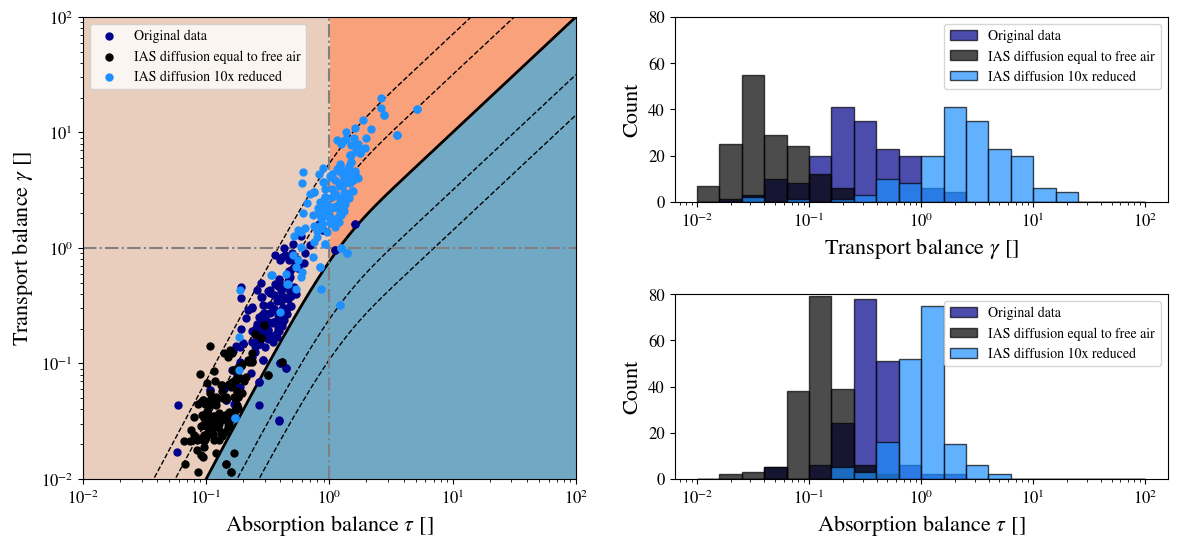

In [16]:
# load data
df = pd.read_csv(ROOT + "data/saved_data/Knauer2022_hypostomatous.csv", sep=';', decimal=',')


N = 400
chi_ = 0.1
vmin, vmax = 0.01, 100
taus = np.exp(np.linspace(np.log(vmin), np.log(vmax), N))
borders = lambda taus, sigma: sigma*taus*np.tanh(taus)



fig = plt.figure(figsize=(14, 6))
spec = fig.add_gridspec(2, 2, hspace=0.5)
ax = fig.add_subplot(spec[:, 0])
ax_hist_tau = fig.add_subplot(spec[1, 1])
ax_hist_gamma = fig.add_subplot(spec[0, 1])

# shading
ax.fill_between(taus, borders(taus, 1), vmin, color=colorI)
ax.fill_between(taus[taus <= 1], vmax, borders(taus[taus <= 1], 1), color=colorII)
ax.fill_between(taus[taus >= 1], vmax, borders(taus[taus >= 1], 1), color=colorIII)
# lines
ax.plot(taus, borders(taus, 1), color='black', linestyle='-', linewidth=2)
ax.plot(taus, borders(taus, np.sqrt(50)), color='black', linestyle='--', linewidth=1)
ax.plot(taus, borders(taus, np.sqrt(10)), color='black', linestyle='--', linewidth=1)
ax.plot(taus, borders(taus, 1/np.sqrt(10)), color='black', linestyle='--', linewidth=1)
ax.plot(taus, borders(taus, 1/np.sqrt(50)), color='black', linestyle='--', linewidth=1)
#
taus, gammas = df['tau'].to_numpy(), df['gamma'].to_numpy()


def scale(taus, gammas, factors):
    ''' 
    Function that scales the taus and gammas by a factor assuming that the geometry factor (porosity/tortuosity) is modified by the same factor.
    taus: np.ndarray of taus
    gammas: np.ndarray of gammas
    factors: np.ndarray of factors to scale the taus and gammas by
    Returns: scaled taus and gammas
    '''
    return taus / np.sqrt(factors), gammas / factors

# plot the case where there is no reduction from regular air diffusion at all
factors = np.zeros_like(taus)
for i in df.index.tolist():
    # cancel the geometry factor applied to the diffusivity in air (datareader_Knauer2022.ipynb)
    factors[i] = 1.57 / df.loc[i, 'fias_mesophyll'] # tortuosity adopted uniformly from Syvertsen et al 1995 (often in the range 1.4-1.6)

taus_as_air, gammas_as_air = scale(taus, gammas, factors)
df_as_air = pd.DataFrame({"tau": taus_as_air, "gamma": gammas_as_air})

# plot a factor 10 larger geometry factor
factors = 0.1*np.ones_like(taus)
taus_10x_lower, gammas_10x_lower = scale(taus, gammas, factors)
df_10x_lower = pd.DataFrame({"tau": taus_10x_lower, "gamma": gammas_10x_lower})

dfs = [df, df_as_air, df_10x_lower]
labels = [r"Original data", r"IAS diffusion equal to free air", r"IAS diffusion 10x reduced"]
colors = ["darkblue", "black", "dodgerblue"]

std_layout(ax, dfs, labels, colors=colors)

# histograms

bins = np.logspace(-2, 2, 21)
alpha = 0.7
ax_hist_tau.hist(taus, bins=bins, alpha=alpha, color="darkblue", edgecolor="black", label="Original data")
ax_hist_tau.hist(taus_as_air, bins=bins, alpha=alpha, color="black", edgecolor="black", label="IAS diffusion equal to free air")
ax_hist_tau.hist(taus_10x_lower, bins=bins, alpha=alpha, color="dodgerblue", edgecolor="black", label="IAS diffusion 10x reduced")
ax_hist_tau.set_ylim(0, 80)
std_histogram(ax_hist_tau, xlabel="tau")

ax_hist_gamma.hist(gammas, bins=bins, alpha=alpha, color="darkblue", edgecolor="black", label="Original data")
ax_hist_gamma.hist(gammas_as_air, bins=bins, alpha=alpha, color="black", edgecolor="black", label="IAS diffusion equal to free air")
ax_hist_gamma.hist(gammas_10x_lower, bins=bins, alpha=alpha, color="dodgerblue", edgecolor="black", label="IAS diffusion 10x reduced")
ax_hist_gamma.set_ylim(0, 80)
std_histogram(ax_hist_gamma, xlabel="gamma")   



plt.savefig(ROOT + "figures/vectorgraphics/supplementary/figureS2.svg")
plt.savefig(ROOT + "figures/vectorgraphics/supplementary/figureS2.png", dpi=300)
plt.show()


### Figure SX - bias in apparent stomatal and intracellular limitations

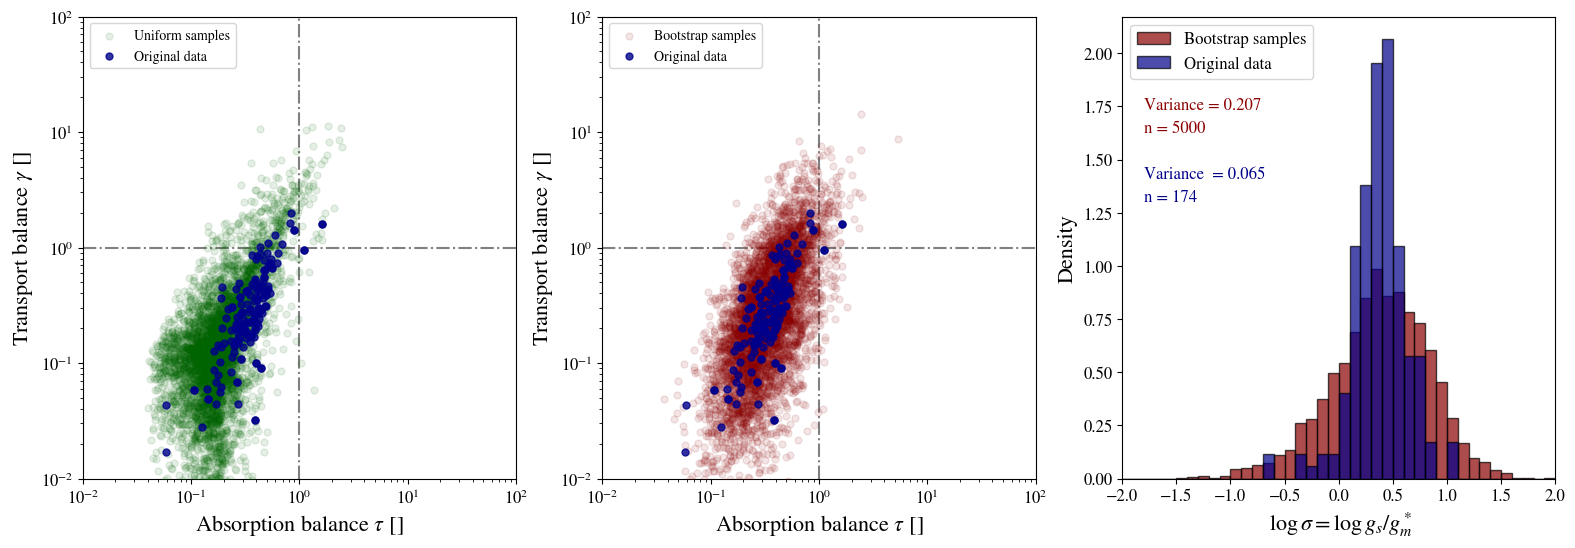

In [32]:
from python_module.interface import numpy_estimate_parameters
np.random.seed(142)  # for reproducibility

# load data
df = pd.read_csv(ROOT + "supplementary/files/data/Knauer2022_pre_tau_gamma.csv", decimal=',', sep=';')
gs = df["stomatal_conductance"].to_numpy()
L = df["mesophyll_thickness"].to_numpy()
Dias = df["ias_conductance"].to_numpy() * L
gias = Dias / L
gm = df["mesophyll_conductance*"].to_numpy()

def get_log_sigmas(taus: np.ndarray, gammas: np.ndarray) -> np.ndarray:
    return np.log10((gammas / (taus * np.tanh(taus))))

taus, gammas = numpy_estimate_parameters(gm, gs, gias)
log_sigmas = get_log_sigmas(taus, gammas)
df = pd.DataFrame({"tau": taus, "gamma": gammas, "log_sigma": log_sigmas})

num_samples = 5_000 

# uniform sampling definition
def uniform_sample(data, size):
    return np.random.uniform(low=np.min(data), high=np.max(data), size=size)
# sample parameters
gs_uniform = uniform_sample(gs, num_samples)
gias_uniform = uniform_sample(gias, num_samples)
gm_uniform = uniform_sample(gm, num_samples)
# calculate tau, gamma, sigma
taus_uniform, gammas_uniform = numpy_estimate_parameters(gm_uniform, gs_uniform, gias_uniform)
log_sigmas_uniform = get_log_sigmas(taus_uniform, gammas_uniform)
df_uniform = pd.DataFrame({"tau": taus_uniform, "gamma": gammas_uniform, "log_sigma": log_sigmas_uniform})


# bootstrap sampling definition
def bootstrap_sample(data, size):
    return np.random.choice(data, size=size, replace=True)     
# sample parameters
gs_boot = bootstrap_sample(gs, num_samples)
L_boot = bootstrap_sample(L, num_samples)
Dias_boot = bootstrap_sample(Dias, num_samples)
gias_boot = Dias_boot / L_boot
gm_boot = bootstrap_sample(gm, num_samples)
# calculate tau, gamma, sigma    
taus_boot, gammas_boot = numpy_estimate_parameters(gm_boot, gs_boot, gias_boot)
log_sigmas_boot = get_log_sigmas(taus_boot, gammas_boot)
df_boot = pd.DataFrame({"tau": taus_boot, "gamma": gammas_boot, "log_sigma": log_sigmas_boot})

figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 6))

# uniform comparison
std_layout(ax1, [df_uniform, df], [r"Uniform samples", r"Original data"], colors=["darkgreen", "darkblue"], alphas=[0.1, 0.8])
# alpha 0.05, 0.8


# bootstrap comparison
std_layout(ax2, [df_boot, df], [r"Bootstrap samples", r"Original data"], colors=["darkred", "darkblue"], alphas=[0.1, 0.8])


# binning sigma histogram

bins = np.linspace(-2, 2, 41)

ax3.hist(log_sigmas_boot, bins=bins, alpha=0.7, edgecolor="black", label="Bootstrap samples", color="darkred", density=True)
ax3.hist(log_sigmas,         bins=bins, alpha=0.7, edgecolor="black", label="Original data", color="darkblue", density=True)
ax3.set_ylabel('Density')
ax3.set_xlabel(r" $\log \sigma = \log g_s/g_m^*$")
ax3.set_xlim(-2, 2)

# annotate variances of the two distributions
var_original = np.var(log_sigmas)
var_bootstrap = np.var(log_sigmas_boot)
ax3.text(-1.8, 0.80 * ax3.get_ylim()[1], f"Variance = {var_bootstrap:.3f}", color="darkred", fontsize=12)
ax3.text(-1.8, 0.75 * ax3.get_ylim()[1], f"n = {num_samples}", color="darkred", fontsize=12)
ax3.text(-1.8, 0.65 * ax3.get_ylim()[1], f"Variance  = {var_original:.3f}", color="darkblue", fontsize=12)
ax3.text(-1.8, 0.60 * ax3.get_ylim()[1], f"n = {len(log_sigmas)}", color="darkblue", fontsize=12)
ax3.legend(fontsize=12)

plt.savefig(ROOT + "figures/vectorgraphics/supplementary/figureS3.svg")
plt.savefig(ROOT + "figures/vectorgraphics/supplementary/figureS3.png", dpi=300)
plt.show()


### Figure SX - hypo- vs. amphistomatous leaves

### Figure SX - Saturating Rubisco kinetics

### Figure SX - Lateral diffusion in 3D

### Figure SX - Non-steady state conditions